In [2]:
import torch
import torch.nn as nn 
import torch.nn.functional as F

from PIL import Image
import matplotlib.pyplot as plt

import numpy as np

from tqdm import tqdm

import gc

In [3]:
LEARNING_RATE = 0.01

N_PRIMARY_SAMPLES = 1000
N_BACKUP_SAMPLES = 0

N_SAMPLES = N_PRIMARY_SAMPLES + N_BACKUP_SAMPLES

IMAGE_SIZE = [256, 256, 3]

In [4]:
def create_window(window_size, channel):
    def gaussian(window_size, sigma):
        gauss = torch.exp(torch.tensor([-(x - window_size//2)**2/float(2*sigma**2) for x in range(window_size)]))
        return gauss/gauss.sum()

    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = torch.autograd.Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())

    return window

def ssim(img1, img2, window_size=11, size_average=True):


    # Assuming the image is of shape [N, C, H, W]
    (_, _, channel) = img1.size()

    img1 = img1.unsqueeze(0).permute(0, 3, 1, 2)
    img2 = img2.unsqueeze(0).permute(0, 3, 1, 2)


    # Parameters for SSIM
    C1 = 0.01**2
    C2 = 0.03**2

    window = create_window(window_size, channel)

    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)

    mu1 = F.conv2d(img1, window, padding=window_size//2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size//2, groups=channel)
    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding=window_size//2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding=window_size//2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding=window_size//2, groups=channel) - mu1_mu2

    SSIM_numerator = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))
    SSIM_denominator = ((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))
    SSIM = SSIM_numerator / SSIM_denominator

    return torch.clamp((1 - SSIM) / 2, 0, 1)

def d_ssim_loss(img1, img2, window_size=11, size_average=True):
    return ssim(img1, img2, window_size, size_average).mean()

# Combined Loss
def combined_loss(pred, target, lambda_param=0.5):
    l1loss = nn.L1Loss()
    return (1 - lambda_param) * l1loss(pred, target) + lambda_param * d_ssim_loss(pred, target)

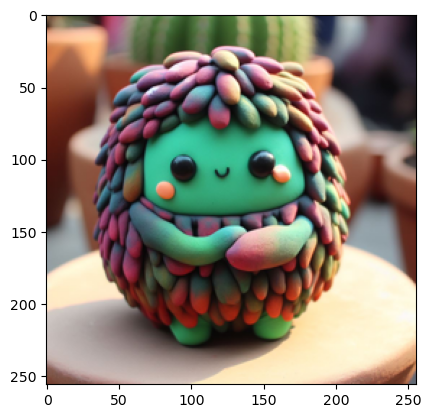

In [5]:
def load_image(image_path):
    image = Image.open(image_path)
    image = image.resize((IMAGE_SIZE[0],IMAGE_SIZE[1]))
    image = image.convert('RGB')
    image = np.array(image)
    image = image / 255.0
    h, w, c = image.shape
    return image, (h, w, c)

image, shape = load_image('Image-01.png')
plt.imshow(image)

In [6]:
device = torch.device('cpu')
image_tensor = torch.tensor(image, dtype=torch.float32, device=device)
image_tensor.shape

torch.Size([256, 256, 3])

In [17]:
coords = np.random.randint(0, [shape[0], shape[1]], size=(N_SAMPLES, 2))
coords = torch.tensor(coords, device=device)

random_pixels = image_tensor[coords[:, 0], coords[:, 1]]

coords_norm = coords / torch.tensor([shape[0]-1, shape[1]-1], device=device).float()
coords_norm = coords_norm * 2 - 1

color_values = image_tensor[coords[:, 0], coords[:, 1]]

sigma_values = torch.rand(N_SAMPLES, 2, device=device)
rho_values = 2 * torch.rand(N_SAMPLES, 1, device=device) - 1
alpha_values = torch.ones(N_SAMPLES, 1, device=device)

sigma_values = torch.logit(sigma_values)
rho_values = torch.atanh(rho_values)
alpha_values = torch.logit(alpha_values)
color_values = torch.logit(color_values)
coords_norm = torch.atanh(coords_norm)

W_values = torch.cat([sigma_values, rho_values, alpha_values, color_values, coords_norm], dim=1)
W_values.shape

torch.Size([1000, 9])

In [18]:
W = nn.Parameter(W_values)
optimizer = torch.optim.Adam([W], lr=LEARNING_RATE)
loss_history = []

In [19]:
xx, yy = torch.arange(shape[0]), torch.arange(shape[1])
x, y = torch.meshgrid(xx, yy, indexing="xy")
x.shape, y.shape

(torch.Size([256, 256]), torch.Size([256, 256]))

In [25]:
def sample_parameters(gaussian_variables):
    # pull the variables
    batch_size = gaussian_variables.shape[0]
    sigma_x = gaussian_variables[:, 0].view(batch_size, 1, 1)
    sigma_y = gaussian_variables[:, 1].view(batch_size, 1, 1)
    rho = gaussian_variables[:, 2].view(batch_size, 1, 1)
    alpha = gaussian_variables[:, 3].view(batch_size, 1)
    colors = gaussian_variables[:, 4:7]
    coords = gaussian_variables[:, 7:9]

    # fix the variables
    sigma_x = F.sigmoid(sigma_x)
    sigma_y = F.sigmoid(sigma_y)
    rho = F.tanh(rho)
    alpha = F.sigmoid(alpha)
    colors = F.sigmoid(colors)
    coords = F.tanh(coords)

    dx, dy = coords[:, 0].view(batch_size, 1, 1), coords[:, 1].view(batch_size, 1, 1)
    
    # weight the colors values with alpha
    colors = colors * alpha
    return batch_size, sigma_x, sigma_y, rho, colors, dx, dy

In [26]:
def sample_gaussians(gaussian_variables, kernel_size=101):
    batch_size, sx, sy, r, colors, dx, dy = sample_parameters(gaussian_variables)

    v = -0.5 * (((sy*dx)**2 + (sx*dy)**2)  - 2*dx*dy*r*sx*sy) / (sx**2 * sy**2 * (1-r**2) + 1e-8)
    print(v.shape)
    v = torch.exp(v)
    
    image = torch.sum(v.unsqueeze(1) * colors.view(batch_size,3,1,1), dim=0)
    image = torch.clamp(image, 0, 1)
    return image

In [27]:
for epoch in tqdm(range(1)):

    gaussian_variables = W
    predicted = sample_gaussians(gaussian_variables)
    loss = combined_loss(predicted, image_tensor, lambda_param=0.2)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

    if(epoch % 10 == 0):
        print(f"Epoch {epoch} -> loss {loss.item()}")
        plt.imshow(predicted.detach().numpy())
        plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]/Users/kiernan/miniforge3/envs/vtub/lib/python3.11/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([256, 256, 3])) that is different to the input size (torch.Size([3, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1000, 1, 1])


RuntimeError: The size of tensor a (3) must match the size of tensor b (256) at non-singleton dimension 0